In [1]:
import mlplol
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

We will use the diabetes regression dataset from sklearn

In [2]:
diabetes = sklearn.datasets.load_diabetes()

def split_data_np(features, target, validation_fraction, test_fraction):
    N = features.shape[0]
    inds_shuffled = np.random.permutation(np.arange(0, N))
    train_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction - validation_fraction)))
    val_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction)))
    train_inds = inds_shuffled[0:train_thresh]
    val_inds = inds_shuffled[train_thresh:val_thresh]
    test_inds = inds_shuffled[val_thresh:]

    trainX = features[train_inds, :]
    trainY = target[train_inds]

    valX = features[val_inds, :]
    valY = target[val_inds]

    testX = features[test_inds, :]
    testY = target[test_inds]

    return dict(trainx=trainX, trainy=trainY, valx=valX, valy=valY, testx=testX, testy=testY)


diabetes_split = split_data_np(diabetes.data, diabetes.target, 0.2, 0.2)

In [3]:
# check the shape
diabetes.data.shape

(442, 10)

We can check that the gradient is correct by making up some weights and checking the computed gradient vs the gradient computed with the finite difference method. We will look at the ratios (should be arrays of ones).

In [4]:
# make some test weights
D_test = 6
wtest1 = np.random.normal(0, 1, (diabetes.data.shape[1]+1, D_test))
wtest2 = np.random.normal(0, 1, (D_test+1, 1))

test_nn_outputs = mlplol.neural_network(diabetes_split['trainx'], [wtest1, wtest2], 'relu')

x_with_biascol = np.c_[np.ones(diabetes_split['trainx'].shape[0]), diabetes_split['trainx']]
y_2dim = np.expand_dims(diabetes_split['trainy'], axis=1)

true_gradient = mlplol.nn_grad(x_with_biascol, y_2dim, test_nn_outputs['a1'], test_nn_outputs['z1'], 
                               test_nn_outputs['output'], [wtest1, wtest2], 'relu')

true_squared_error = mlplol.squared_loss(y_2dim, test_nn_outputs['output'])

eps = np.sqrt(np.finfo(float).eps)

finite_difference_grad = mlplol.calc_approx_grad([wtest1, wtest2], diabetes_split['trainx'], y_2dim, 
                                                 eps, true_squared_error, 'relu')

print([(i+eps)/(j+eps) for i,j in zip(true_gradient, finite_difference_grad)]) # we add eps to avoid zero division

[array([[1.00019105, 1.        , 1.        , 1.        , 1.00000058,
        0.99999965],
       [1.00037951, 1.        , 1.        , 1.        , 1.00024907,
        0.99966499],
       [0.99341827, 1.        , 1.        , 1.        , 1.00017629,
        1.00114209],
       [0.99798361, 1.        , 1.        , 1.        , 1.000086  ,
        0.99987656],
       [0.9984002 , 1.        , 1.        , 1.        , 0.99998486,
        0.99967739],
       [1.01188903, 1.        , 1.        , 1.        , 1.00016589,
        0.99927238],
       [0.99831867, 1.        , 1.        , 1.        , 1.00023483,
        0.99990436],
       [1.00240692, 1.        , 1.        , 1.        , 0.99987867,
        1.00007765],
       [0.99371718, 1.        , 1.        , 1.        , 1.00005704,
        0.99992741],
       [1.0029313 , 1.        , 1.        , 1.        , 1.00002333,
        0.999879  ],
       [0.99709373, 1.        , 1.        , 1.        , 0.99997842,
        0.99992292]]), array([[0.99999953

In [5]:
test_nn_outputs['output'].shape

(265, 1)

We train a model.

In [6]:
diabetes_nn = mlplol.NNregressor_onelayer(activation_function = 'relu')
diabetes_nn.estimate_weights(diabetes_split['trainx'], diabetes_split['trainy'], diabetes_split['valx'],
                             diabetes_split['valy'], n_hidden=100,
                              iterations=100, patience=10, rate=0.001,
                              verbose=False, weight_initialization_factors=None)

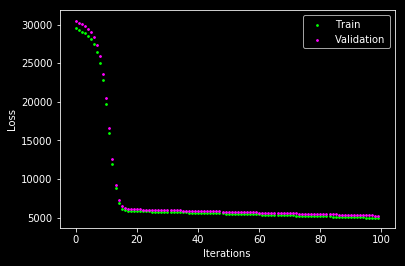

In [7]:
plt.style.use("dark_background")
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

Check test loss

In [8]:
test_pred = diabetes_nn.predict(diabetes_split['testx'])
test_loss = mlplol.squared_loss(test_pred, diabetes_split['testy'])
print('test loss: ', test_loss)

test loss:  4585.413885239775


We can also try auto encoding, demonstrated using the iris dataset.

In [9]:
iris = sklearn.datasets.load_iris()

In [10]:
iris.data.shape

(150, 4)

In [11]:
iris_split = split_data_np(iris.data, iris.target, 0.2, 0.2)

In [12]:
iris_ae = mlplol.NNregressor_onelayer(activation_function = 'softsign')
iris_ae.estimate_weights(iris_split['trainx'], iris_split['trainx'], iris_split['valx'],
                             iris_split['valx'], n_hidden=2, 
                              iterations=10000, patience=10, rate=0.001, 
                              verbose=False, weight_initialization_factors=None)

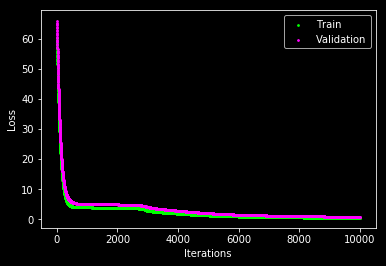

In [13]:
plt.style.use("dark_background")
plt.scatter(np.arange(iris_ae.iterations), iris_ae.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(iris_ae.iterations), iris_ae.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

In [14]:
test_reconstructions = iris_ae.predict(iris_split['testx'])
test_loss_ae = mlplol.squared_loss(iris_split['testx'], test_reconstructions)
print('test loss post train: ', test_loss_ae)

test loss post train:  0.6642849793680548


In [15]:
iris_code = iris_ae.encode(iris.data)

In [16]:
iris_code.shape

(150, 2)

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)
pca.fit(iris.data)
iris_pca = pca.transform(iris.data)

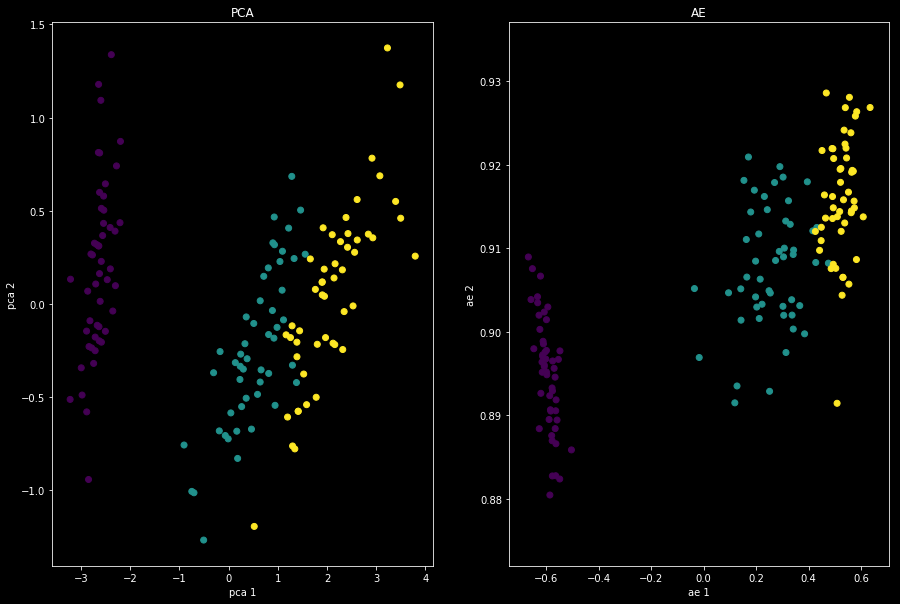

In [19]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].scatter(iris_pca[:, 0], iris_pca[:, 1], c=iris.target)
ax[0].set_xlabel('pca 1')
ax[0].set_ylabel('pca 2')
ax[0].set_title('PCA')

ax[1].scatter(iris_code[:, 0], iris_code[:, 1], c=iris.target)
ax[1].set_xlabel('ae 1')
ax[1].set_ylabel('ae 2')
ax[1].set_title('AE')

plt.show()